# Computations
## Data import

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import scipy
import itertools
import pickle
import time
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF as sm_ECDF
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import concurrent.futures
import attila_utils
import gem_tools

In [2]:
groupdict = {
    #'m-control': ('all_control', 'MSBB'),
    'm-AD-A': ('SubtypeA_AD', 'MSBB'),
    'm-AD-B1': ('SubtypeB1_AD', 'MSBB'),
    'm-AD-B2': ('SubtypeB2_AD', 'MSBB'),
    'm-AD-C1': ('SubtypeC1_AD', 'MSBB'),
    'm-AD-C2': ('SubtypeC2_AD', 'MSBB'),
}
ar = gem_tools.read_active_reactions(groupdict=groupdict)

In [3]:
vcp_p = 0.2
fe_p = 2
fit_method = 'fit_vb'
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']
subsys = gemsubsys.unique()[2]
data = gem_tools.long_ar_subsys([subsys], ar=ar, gemsubsys=gemsubsys)
random = {'Subtypes': 'disease_state', 'Reactions': 'rxn_ID', 'Subjects': 'subject_ID'}
formula = 'rxn_state ~ 1'
md = BinomialBayesMixedGLM.from_formula(formula, random, data, vcp_p=vcp_p, fe_p=fe_p)
fit = getattr(md, fit_method)
m = fit()
m.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-0.5524,0.0664,,,
Subtypes,V,-0.1345,0.1881,0.874,0.600,1.273
Reactions,V,1.4838,0.0842,4.410,3.727,5.218
Subjects,V,-0.3125,0.0567,0.732,0.653,0.819


In [4]:
data

rxn_state disease_state    rxn_ID  \
ID                                                                  
MAR03944 P19B648.BM_36_517              1        m-AD-A  MAR03944   
         S110B355.BM_36_308             1        m-AD-A  MAR03944   
         P19B648.BM_36_518              1        m-AD-A  MAR03944   
         P19B648.BM_36_545              1        m-AD-A  MAR03944   
         S111B355.BM_36_398             1        m-AD-A  MAR03944   
...                                   ...           ...       ...   
MAR01472 S111B355.BM_36_384             0       m-AD-C2  MAR01472   
         E007C014.hB_RNA_10567          0       m-AD-C2  MAR01472   
         S151B648.BM_36_495             0       m-AD-C2  MAR01472   
         S111B355.BM_36_425             0       m-AD-C2  MAR01472   
         E007C014.hB_RNA_10632          0       m-AD-C2  MAR01472   

                                           subject_ID  
ID                                                     
MAR03944 P19B648.BM_36_517          P19B648.BM_36_517  
         S110B355.BM_36_308        S110B355.BM_36_308  
         P19B648.BM_36_518          P19B648.BM_36_518  
         P19B648.BM_36_545          P19B648.BM_36_545  
         S111B355.BM_36_398        S111B355.BM_36_398  
...                                               ...  
MAR01472 S111B355.BM_36_384        S111B355.BM_36_384  
         E007C014.hB_RNA_10567  E007C014.hB_RNA_10567  
         S151B648.BM_36_495        S151B648.BM_36_495  
         S111B355.BM_36_425        S111B355.BM_36_425  
         E007C014.hB_RNA_10632  E007C014.hB_RNA_10632  

[3171 rows x 4 columns]

## Modeling

For a given subsystem (metabolic pathway), we model the reaction state with the following mixed effects model:

rxn state $\sim$ 1 + ($1 | $ AD subtype) + ($1 | $ Reaction),

where rxn state is a binary variable, 1 is a fixed intercept term, ($1 | $ AD subtype) is a random intercept term for the AD subtypes, and ($1 | $ Reaction) is another random intercept term: for Reactions.  Thus (beside random error, which is implicit in the above expression), we have two variance components: AD subtypes and Reactions.  We also considered an extended model with an additional, third random variance component, subjects, nested within AD subtypes.  However, we dropped this extended model due to convergence issues during fitting it to the data (not shown).

In a more mathematical notation, our model is expressed as: 

$E(Y|x_1, x_2) = g^{-1}(\beta_0 + b_1 x_1 + b_2 x_2)$,

where $Y$ is the reaction state and $X$ is a vector of AD subtype and reaction ID.  $Y$ conditioned on $X$ is a binomial random variable.  The link function $g$ transforms the linear predictor on the right hand side into the expected $Y$ for a given $X$.  While the intercept $\beta_0$ is fixed, the $b_1$ and $b_2$ parameters are random with zero mean and variance $V_1$ and $V_2$, for AD subtype and reaction, respectively.

We estimated $V_1$ and $V_2$ with Bayesian inference using the `BinomialBayesMixedGLM` model class of the `statsmodels` Python package.  We present below the posterior mean and standard deviation (stdev) of $V_1$ and $V_2$ expressing the random effect (variance component) for AD subtype and reaction, respectively.

In [5]:
random={'Subtypes': 'disease_state', 'Reactions': 'rxn_ID'}
subsys = gemsubsys.unique()[2]
print(subsys)
m = gem_tools.myBinomialBayesRandomGLM([subsys], random=random, ar=ar, vcp_p=0.2, fe_p=2, fit_method='fit_map')
m.summary()

Galactose metabolism


,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-0.6494,1.7671,,,
Subtypes,V,-0.1484,0.1919,0.862,0.587,1.265
Reactions,V,1.2927,0.1038,3.643,2.960,4.483


In [6]:
random={'Subtypes': 'disease_state'}
subsys = gemsubsys.unique()[2]
print(subsys)
m = gem_tools.myBinomialBayesRandomGLM([subsys], random=random, ar=ar, vcp_p=0.2, fe_p=2, fit_method='fit_map')
m.summary()

Galactose metabolism


,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,0.3072,0.7637,,,
Subtypes,V,-0.1937,0.1989,0.824,0.554,1.226


In [7]:
fpath = '../../results/2025-05-25-ad-subtype-random-fx/fitted_models.pickle'
if os.path.exists(fpath):
    print('exists')
    with open(fpath, 'rb') as f:
        fitted_models = pickle.load(f)
else:
    subsystems = gemsubsys.unique()
    random = {'Subtypes': 'disease_state', 'Reactions': 'rxn_ID'}
    d = {subsys: gem_tools.myBinomialBayesRandomGLM([subsys], random=random, ar=ar, vcp_p=0.2, fe_p=2, fit_method='fit_map') for subsys in subsystems}
    fitted_models = pd.Series(d)
    with open(fpath, 'wb') as f:
        pickle.dump(fitted_models, f)

exists


# Results

Below are the posterior mean and standard deviation for the two variance components: AD subtypes and Reactions, respectively.  We can see that for the Acyl-CoA hydrolysis pathway Subtypes contribute substantially to the overall variance in reaction activity, although Reactions differ even more in activity for this pathway.  For all other pathways the estimated variance component for Subtypes is negligible (comparable to our error of estimation expressed by the standard deviance of the estimate).  For many pathways, the estimated variance for Subtypes is negative, which is mathematically impossible; this indicates a strong bias and calls into question the results.

In [8]:
ix = pd.MultiIndex.from_product([['Subtypes', 'Reactions'], ['mean', 'stdev']])
vcp_estim = fitted_models.dropna().apply(lambda m: pd.Series([m.vcp_mean[0], m.vcp_sd[0], m.vcp_mean[1], m.vcp_sd[1]], index=ix))
vcp_estim = vcp_estim.sort_values(('Subtypes', 'mean'), ascending=False)
vcp_estim

Subtypes            \
                                                        mean     stdev   
Acyl-CoA hydrolysis                                 0.433030  0.141009   
Chondroitin sulfate degradation                     0.196213  0.151013   
Beta oxidation of branched-chain fatty acids (m...  0.158158  0.177318   
Keratan sulfate degradation                         0.145885  0.159221   
Carnitine shuttle (mitochondrial)                   0.069403  0.165362   
...                                                      ...       ...   
Fatty acid oxidation                               -0.198412  0.199741   
Eicosanoid metabolism                              -0.198526  0.199883   
Beta oxidation of even-chain fatty acids (perox... -0.198970  0.199836   
Lipoic acid metabolism                             -0.199007  0.200177   
Artificial reactions                               -0.199121  0.200158   

                                                   Reactions            
                                                        mean     stdev  
Acyl-CoA hydrolysis                                 0.578702  0.084623  
Chondroitin sulfate degradation                     0.902637  0.091334  
Beta oxidation of branched-chain fatty acids (m... -0.347457  0.211399  
Keratan sulfate degradation                         1.112690  0.074233  
Carnitine shuttle (mitochondrial)                   0.445418  0.074815  
...                                                      ...       ...  
Fatty acid oxidation                                1.637815  0.034006  
Eicosanoid metabolism                               1.435973  0.077497  
Beta oxidation of even-chain fatty acids (perox...  1.607062  0.082999  
Lipoic acid metabolism                              1.309296  0.114957  
Artificial reactions                                1.388042  0.102484  

[128 rows x 4 columns]

The figure shows some of the notions discussed before: Reactions vary more in activity within a most pathways than AD subtypes do.  We see that negative, biased variance estimates for both AD subtypes and Reactions.

['named-figure/variance-components.png',
 'named-figure/variance-components.pdf']

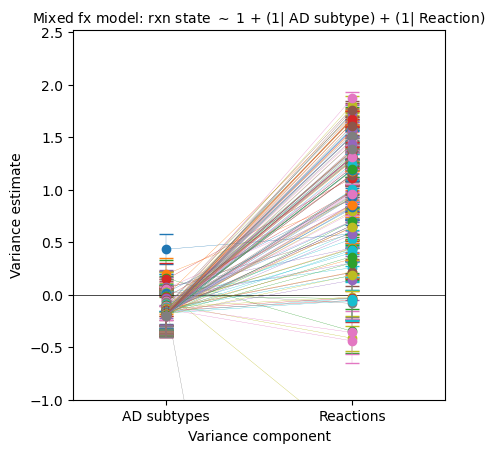

In [9]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
for subsystem in vcp_estim.index:
    s, r = vcp_estim.loc[subsystem].xs('mean', level=1).to_list()
    s_err, r_err = vcp_estim.loc[subsystem].xs('stdev', level=1).to_list()
    #ax.plot([0, 1], [s, r], marker='o', linewidth=0.2)
    ax.errorbar([0, 1], [s, r], yerr=[s_err, r_err], marker='o', linewidth=0.2, capsize=5)


ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-1, ax.get_ylim()[1])
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(['AD subtypes', 'Reactions'])
ax.set_xlabel('Variance component')
ax.set_ylabel('Variance estimate')
ax.set_title(r'Mixed fx model: rxn state $\sim$ 1 + $(1 | $ AD subtype) + $(1 | $ Reaction)', fontsize=10)
attila_utils.savefig(fig, 'variance-components')

In [10]:
data = gem_tools.long_ar_subsys(['Acyl-CoA hydrolysis'], ar=ar, gemsubsys=gemsubsys)
data

rxn_state disease_state    rxn_ID  \
ID                                                                  
MAR00154 P19B648.BM_36_517              1        m-AD-A  MAR00154   
         S110B355.BM_36_308             1        m-AD-A  MAR00154   
         P19B648.BM_36_518              1        m-AD-A  MAR00154   
         P19B648.BM_36_545              1        m-AD-A  MAR00154   
         S111B355.BM_36_398             1        m-AD-A  MAR00154   
...                                   ...           ...       ...   
MAR03477 S111B355.BM_36_384             1       m-AD-C2  MAR03477   
         E007C014.hB_RNA_10567          1       m-AD-C2  MAR03477   
         S151B648.BM_36_495             1       m-AD-C2  MAR03477   
         S111B355.BM_36_425             1       m-AD-C2  MAR03477   
         E007C014.hB_RNA_10632          1       m-AD-C2  MAR03477   

                                           subject_ID  
ID                                                     
MAR00154 P19B648.BM_36_517          P19B648.BM_36_517  
         S110B355.BM_36_308        S110B355.BM_36_308  
         P19B648.BM_36_518          P19B648.BM_36_518  
         P19B648.BM_36_545          P19B648.BM_36_545  
         S111B355.BM_36_398        S111B355.BM_36_398  
...                                               ...  
MAR03477 S111B355.BM_36_384        S111B355.BM_36_384  
         E007C014.hB_RNA_10567  E007C014.hB_RNA_10567  
         S151B648.BM_36_495        S151B648.BM_36_495  
         S111B355.BM_36_425        S111B355.BM_36_425  
         E007C014.hB_RNA_10632  E007C014.hB_RNA_10632  

[9664 rows x 4 columns]

In [11]:
def get_frac_active_rxn(subsys):
    data = gem_tools.long_ar_subsys([subsys], ar=ar, gemsubsys=gemsubsys)
    s = data.groupby('disease_state').apply(lambda df: df.rxn_state.sum() / df.shape[0])
    df = s.to_frame(subsys).transpose()
    return df

l = [get_frac_active_rxn(subsys) for subsys in vcp_estim.index]

In [12]:
frac_active_rxn = pd.concat(l)
frac_active_rxn.columns = pd.MultiIndex.from_product([['Fraction of active reactions'], frac_active_rxn.columns])
entropy = frac_active_rxn.apply(scipy.stats.entropy, axis=1).to_frame(('Entropy', ''))

results = pd.concat([vcp_estim, frac_active_rxn, entropy], axis=1)
results.to_csv('../../results/2025-05-25-ad-subtype-random-fx/AD-subtype-variance.xlsx')
results

Subtypes            \
                                                        mean     stdev   
Acyl-CoA hydrolysis                                 0.433030  0.141009   
Chondroitin sulfate degradation                     0.196213  0.151013   
Beta oxidation of branched-chain fatty acids (m...  0.158158  0.177318   
Keratan sulfate degradation                         0.145885  0.159221   
Carnitine shuttle (mitochondrial)                   0.069403  0.165362   
...                                                      ...       ...   
Fatty acid oxidation                               -0.198412  0.199741   
Eicosanoid metabolism                              -0.198526  0.199883   
Beta oxidation of even-chain fatty acids (perox... -0.198970  0.199836   
Lipoic acid metabolism                             -0.199007  0.200177   
Artificial reactions                               -0.199121  0.200158   

                                                   Reactions            \
                                                        mean     stdev   
Acyl-CoA hydrolysis                                 0.578702  0.084623   
Chondroitin sulfate degradation                     0.902637  0.091334   
Beta oxidation of branched-chain fatty acids (m... -0.347457  0.211399   
Keratan sulfate degradation                         1.112690  0.074233   
Carnitine shuttle (mitochondrial)                   0.445418  0.074815   
...                                                      ...       ...   
Fatty acid oxidation                                1.637815  0.034006   
Eicosanoid metabolism                               1.435973  0.077497   
Beta oxidation of even-chain fatty acids (perox...  1.607062  0.082999   
Lipoic acid metabolism                              1.309296  0.114957   
Artificial reactions                                1.388042  0.102484   

                                                   Fraction of active reactions  \
                                                                         m-AD-A   
Acyl-CoA hydrolysis                                                    0.954455   
Chondroitin sulfate degradation                                        0.544971   
Beta oxidation of branched-chain fatty acids (m...                     1.000000   
Keratan sulfate degradation                                            0.861422   
Carnitine shuttle (mitochondrial)                                      0.932751   
...                                                                         ...   
Fatty acid oxidation                                                   0.617184   
Eicosanoid metabolism                                                  0.384752   
Beta oxidation of even-chain fatty acids (perox...                     0.846809   
Lipoic acid metabolism                                                 0.125000   
Artificial reactions                                                   0.500000   

                                                                        \
                                                     m-AD-B1   m-AD-B2   
Acyl-CoA hydrolysis                                 0.955078  0.954167   
Chondroitin sulfate degradation                     0.294508  0.406818   
Beta oxidation of branched-chain fatty acids (m...  1.000000  0.938462   
Keratan sulfate degradation                         0.802632  0.822368   
Carnitine shuttle (mitochondrial)                   0.953497  0.983929   
...                                                      ...       ...   
Fatty acid oxidation                                0.616094  0.612723   
Eicosanoid metabolism                               0.385417  0.386667   
Beta oxidation of even-chain fatty acids (perox...  0.842500  0.850667   
Lipoic acid metabolism                              0.125000  0.125000   
Artificial reactions                                0.500000  0.500000   

                                                                        \
         

We evaluated the fraction of active reactions for each AD subtype and pathway and, based on that, calculated information entropy for each pathway.  For most pathway, AD subtypes are quite similar to each other in terms of the fraction and therefore the entropy is close to the theoretical maximum, which indicates the uniformity of subtypes.  However, subtle differences in the fraction of active reactions might be still physiologically relevant. 

In [13]:
results.sort_values(('Entropy', ''), ascending=True)

Subtypes            \
                                                        mean     stdev   
Hippurate metabolism                               -0.150099  0.205363   
Beta oxidation of odd-chain fatty acids (peroxi... -0.133927  0.202548   
CoA catabolism                                     -0.161914  0.200862   
Vitamin C metabolism                               -0.130744  0.200538   
Thiamine metabolism                                 0.060202  0.169351   
...                                                      ...       ...   
Fatty acid desaturation (even-chain)               -0.136274  0.209224   
Peptide metabolism                                 -0.067976  0.216155   
Lipoic acid metabolism                             -0.199007  0.200177   
Aminoacyl-tRNA biosynthesis                        -0.182302  0.202862   
Artificial reactions                               -0.199121  0.200158   

                                                   Reactions            \
                                                        mean     stdev   
Hippurate metabolism                               -0.053049  0.203459   
Beta oxidation of odd-chain fatty acids (peroxi... -0.032102  0.201088   
CoA catabolism                                     -0.036023  0.200541   
Vitamin C metabolism                                0.216567  0.177081   
Thiamine metabolism                                 0.583037  0.140133   
...                                                      ...       ...   
Fatty acid desaturation (even-chain)               -0.439695  0.207151   
Peptide metabolism                                 -9.680219  0.200000   
Lipoic acid metabolism                              1.309296  0.114957   
Aminoacyl-tRNA biosynthesis                         0.573837  0.119786   
Artificial reactions                                1.388042  0.102484   

                                                   Fraction of active reactions  \
                                                                         m-AD-A   
Hippurate metabolism                                                   0.000000   
Beta oxidation of odd-chain fatty acids (peroxi...                     0.085106   
CoA catabolism                                                         0.148936   
Vitamin C metabolism                                                   0.202128   
Thiamine metabolism                                                    0.340426   
...                                                                         ...   
Fatty acid desaturation (even-chain)                                   0.998227   
Peptide metabolism                                                     0.999736   
Lipoic acid metabolism                                                 0.125000   
Aminoacyl-tRNA biosynthesis                                            0.952381   
Artificial reactions                                                   0.500000   

                                                                        \
                                                     m-AD-B1   m-AD-B2   
Hippurate metabolism                                0.000000  0.000000   
Beta oxidation of odd-chain fatty acids (peroxi...  0.041667  0.033333   
CoA catabolism                                      0.125000  0.100000   
Vitamin C metabolism                                0.145833  0.183333   
Thiamine metabolism                                 0.166667  0.142857   
...                                                      ...       ...   
Fatty acid desaturation (even-chain)                1.000000  1.000000   
Peptide metabolism                                  1.000000  0.999725   
Lipoic acid metabolism                              0.125000  0.125000   
Aminoacyl-tRNA biosynthesis                         0.952381  0.952381   
Artificial reactions                                0.500000  0.500000   

                                                                        \
         

The figure shows that model-agnostic entropy and the model-based variance component of Subtypes do not agree well with each other although there is some agreement.

(1.58, 1.61)

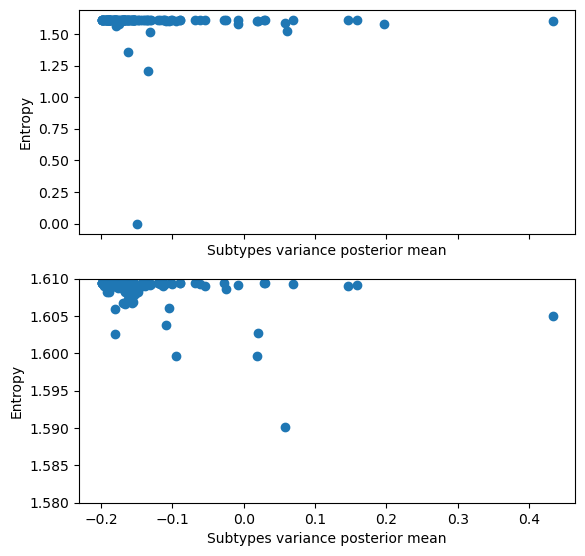

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6.4, 6.4))

def my_scatter(ax):
    ax.scatter(x=results[('Subtypes', 'mean')], y=results[('Entropy', '')])
    ax.set_xlabel('Subtypes variance posterior mean')
    ax.set_ylabel('Entropy')
    return ax

my_scatter(ax[0])
my_scatter(ax[1])
ax[1].set_ylim(1.58, 1.61)

In [15]:
%connect_info

{
  "shell_port": 57603,
  "iopub_port": 45015,
  "stdin_port": 52411,
  "control_port": 41603,
  "hb_port": 54377,
  "ip": "127.0.0.1",
  "key": "24c4e683-c66b4b310e14c17764d35b96",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-eeb5266c-74ed-44f2-bac7-2a0d7e4a2538.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
